In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from python import plots, visualization
from python.model import LayerModel, BiLrp, SuspiciousModel

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
batch_size = 64
epochs = 8
IMG_HEIGHT = 240
IMG_WIDTH = 240

model_path = '../models/brats19_hgglgg_4.h5'

In [5]:
y = Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='input_layer')
x = Conv2D(16, 3, padding='same', activation='relu', name='conv_a')(y)
x = MaxPooling2D(name='max_a')(x)
x = Dropout(0.2,name='drop_a')(x)
x = Conv2D(32, 3, padding='same', activation='relu', name='conv_b')(x)
x = MaxPooling2D(name='max_b')(x)
x = Conv2D(64, 3, padding='same', activation='relu', name='conv_c')(x)
x = MaxPooling2D(name='max_c')(x)
x = Conv2D(128, 3, padding='same', activation='relu', name='conv_d')(x)
x = MaxPooling2D(name='max_d')(x)
x = Dropout(0.2, name='drop_c')(x)
x = Flatten(name='flat_a')(x)
x = Dense(64, activation='relu', name='dense_a')(x)
x = Dense(2, name='dense_b')(x)
model = Model(y, x)

In [7]:
train_dir = '../data/train/confidence_19/'
val_dir = '../data/valid/confidence_19/'
test_dir = '../data/test/confidence_19/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

Found 1645 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [7]:
sample_training_images, l = next(train_data_gen)
sample_training_images.shape

(64, 240, 240, 3)

[0. 1. 0. 0. 1.]


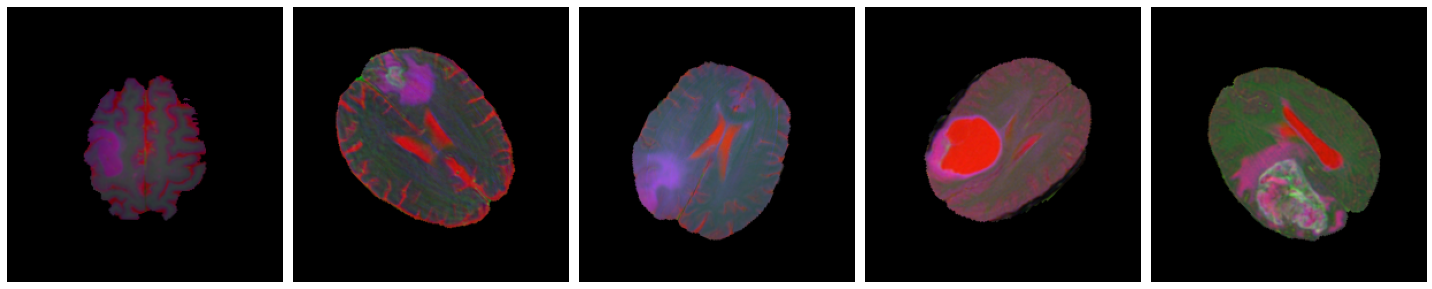

In [8]:
print(l[:5])
plots.plot_rgb_images(sample_training_images[:5])

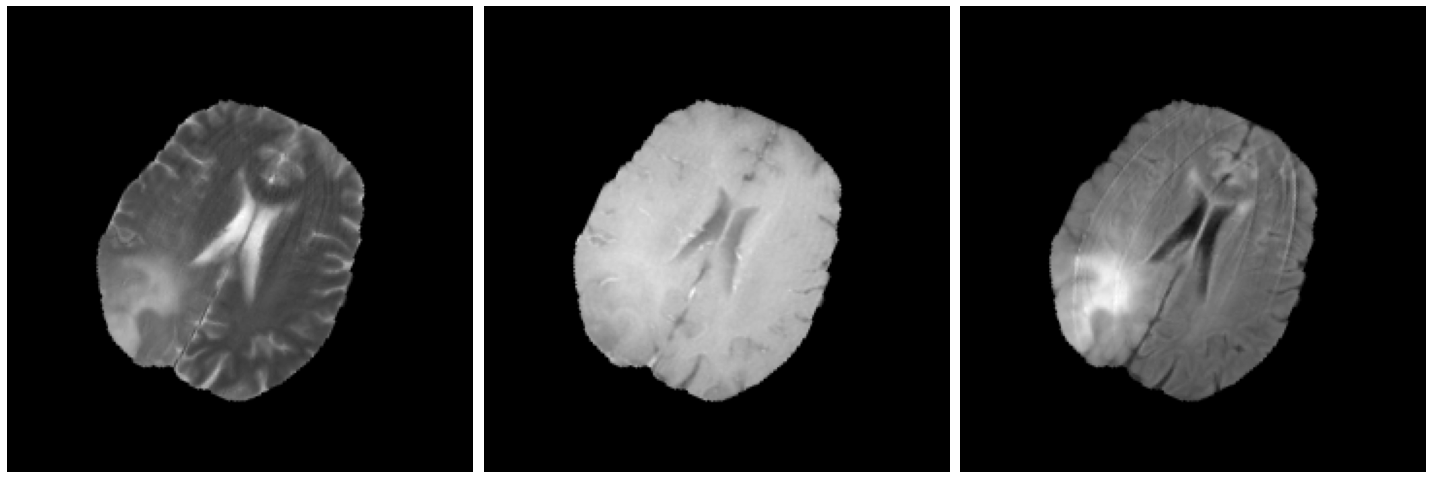

In [9]:
plots.plot_rgb_decomposition(sample_training_images[2])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=1645 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=446 // batch_size
)

Train for 25 steps, validate for 6 steps
Epoch 1/8
25/25 [==============================] - 17s 666ms/step - loss: 0.6974 - accuracy: 0.4877 - val_loss: 0.6924 - val_accuracy: 0.4479
Epoch 2/8
25/25 [==============================] - 17s 665ms/step - loss: 0.6598 - accuracy: 0.6173 - val_loss: 0.6635 - val_accuracy: 0.5755
Epoch 3/8
25/25 [==============================] - 17s 670ms/step - loss: 0.6003 - accuracy: 0.6799 - val_loss: 0.6200 - val_accuracy: 0.6042
Epoch 4/8
25/25 [==============================] - 16s 648ms/step - loss: 0.5815 - accuracy: 0.6856 - val_loss: 0.6446 - val_accuracy: 0.5703
Epoch 5/8
25/25 [==============================] - 15s 617ms/step - loss: 0.5537 - accuracy: 0.7008 - val_loss: 0.6628 - val_accuracy: 0.6667
Epoch 6/8
25/25 [==============================] - 16s 640ms/step - loss: 0.5302 - accuracy: 0.7211 - val_loss: 0.6566 - val_accuracy: 0.6849
Epoch 7/8
25/25 [==============================] - 16s 638ms/step - loss: 0.4995 - accuracy: 0.7268 - val_l

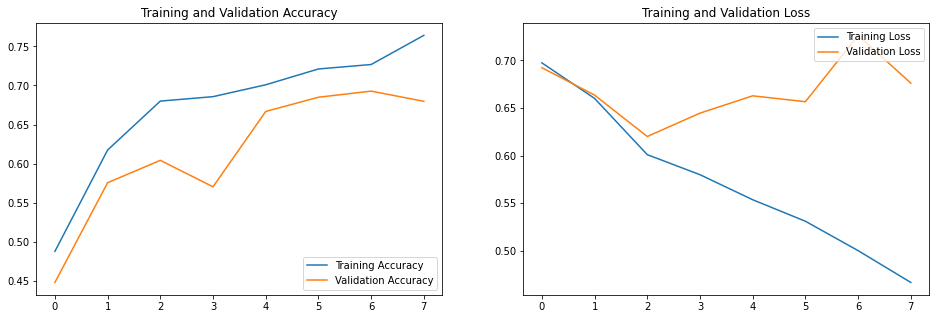

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model performance:
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.64       195
         1.0       0.72      0.71      0.72       251

    accuracy                           0.69       446
   macro avg       0.68      0.68      0.68       446
weighted avg       0.69      0.69      0.69       446



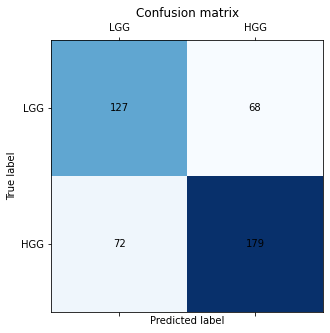

In [13]:
y_true_v = []
pred_v = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(val_data_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred_v.extend(p)
    y_true_v.extend(labels)
plots.plot_model_performance(y_true_v, pred_v)

Model performance:
              precision    recall  f1-score   support

         0.0       0.75      0.55      0.64       203
         1.0       0.69      0.84      0.76       235

    accuracy                           0.71       438
   macro avg       0.72      0.70      0.70       438
weighted avg       0.72      0.71      0.70       438



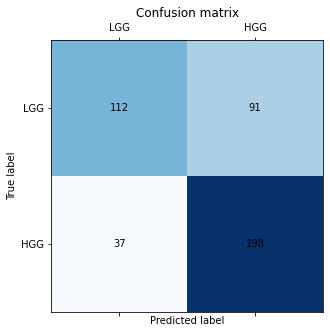

In [14]:
y_true_t = []
pred_t = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(test_data_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred_t.extend(p)
    y_true_t.extend(labels)
plots.plot_model_performance(y_true_t, pred_t)

In [15]:
# Save the model
model.save('../models/brats19_3.h5');

## Evaluate model

In [5]:
model = load_model('../models/brats19_5.h5')

In [8]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse',
                                                           seed=42)
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse',
                                                           seed=42)

Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [9]:
a_images = []
a_labels = []
a_pred = []
b_images = []
b_labels = []
b_pred = []
for _ in range(round(val_data_gen.samples / batch_size)):
    (images, labels) = val_data_gen.next()
    a_images.extend(images)
    a_labels.extend(labels)
    a_pred.extend(model.predict(images).argmax(1))
for _ in range(round(test_data_gen.samples / batch_size)):
    (images, labels) = test_data_gen.next()
    b_images.extend(images)
    b_labels.extend(labels)
    b_pred.extend(model.predict(images).argmax(1))
    
a_images = np.array(a_images)
a_labels = np.array(a_labels)
a_pred = np.array(a_pred)
b_images = np.array(b_images)
b_labels = np.array(b_labels)
b_pred = np.array(b_pred)

In [10]:
model.layers

In [11]:
# model with layers outputs
layers_model = SuspiciousModel(model, [5, 7, 9, 12], ["HGG", "LGG"])

In [12]:
layers_model.train(a_images, a_labels, a_pred)

In [13]:
pred = layers_model.predict(b_images[b_pred==0], 0)

Analysis of cases predicted as HGG


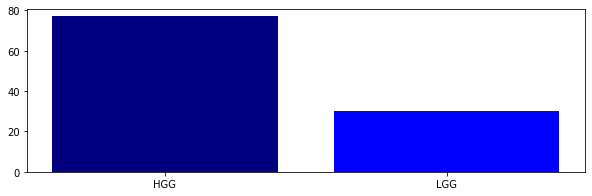

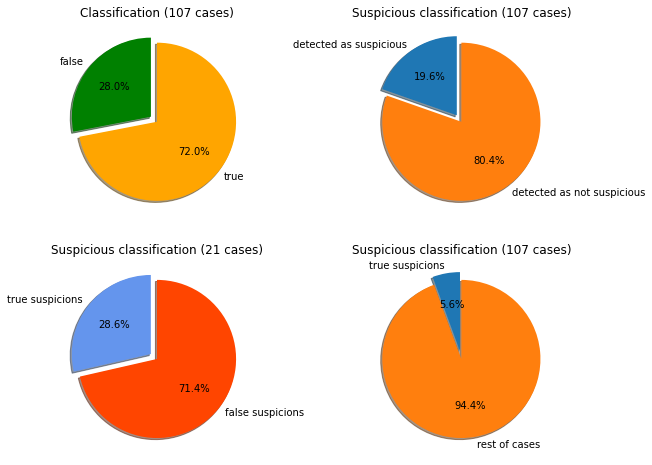

In [14]:
visualization.plot_suspicions_stats(pred, b_labels[b_pred==0], 0, ["HGG", "LGG"])

In [15]:
label = 0

susp_imgs = b_images[b_pred == label][pred]

susp_labels = b_labels[b_pred == label][pred]

In [16]:
susp_idx = layers_model.layer_models[0].get_neighbours_idx(susp_imgs)

In [17]:
image_idx = 0

image = susp_imgs[image_idx]
true_label = susp_labels[image_idx]
idx = susp_idx[image_idx]

In [18]:
class_names=["HGG", "LGG"]

In [19]:
bi_lrp = layers_model.layer_models[1].analyze_pair_bilrp(image, a_images[168], [8], 20)

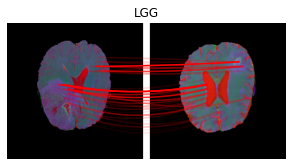

In [20]:
visualization.plot_relevances_full(bi_lrp, image, a_images[168], [8], title=class_names[int(a_labels[168])])

In [21]:
susp_idx = layers_model.layer_models[1].get_neighbours_idx(np.array([image]))

In [22]:
susp_idx

array([[109,  82,  39,  40,  10]])

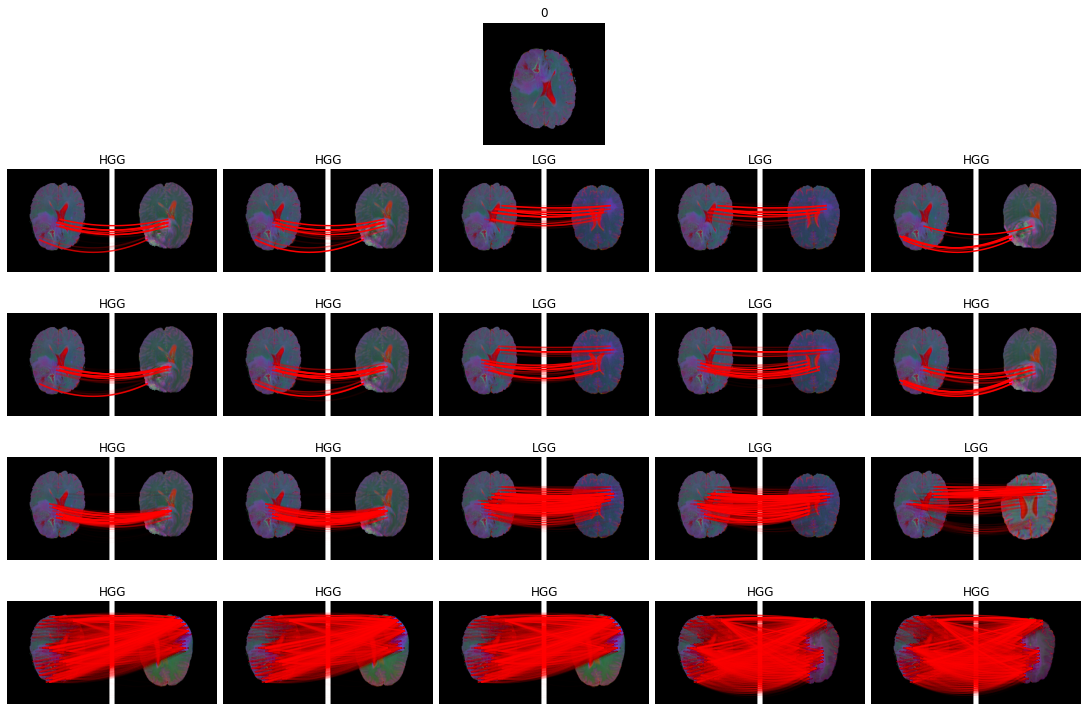

In [23]:
fig3 = plt.figure(constrained_layout=True, figsize = (15,10))
gs = fig3.add_gridspec(5, 5)

visualization.plot_rgb(image, gs[0, :].subgridspec(1, 1).subplots(), str(int(true_label)))

for l in range(4):
    susp_idx = layers_model.layer_models[l].get_neighbours_idx(np.array([image]))
    idx = susp_idx[0]

    for n, i in enumerate(idx):
        bi_lrp = layers_model.layer_models[l].analyze_pair_bilrp(image, a_images[i], [8], 20)
        visualization.plot_relevances_full(bi_lrp, image, a_images[i], [8], gs=gs[l+1, n], title=class_names[int(a_labels[i])])

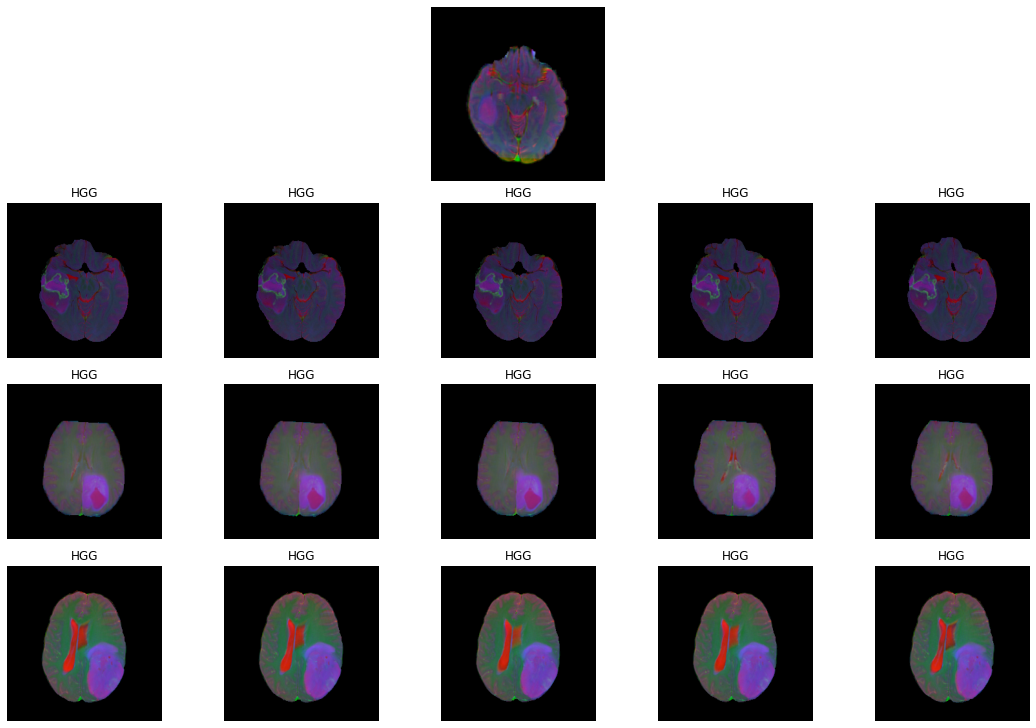

In [23]:
image_idx = 0

image = susp_imgs[image_idx]
true_label = susp_labels[image_idx]
idx = susp_idx[image_idx]

fig3 = plt.figure(constrained_layout=True, figsize = (15,10))
gs = fig3.add_gridspec(2, 2, height_ratios = [1, 3])
visualization.visualize_image(
    image,
    true_label,
    label,
    gs[0,:]
)
visualization.visualize_path(
    layers_neighbours_idxs,
    a_images,
    a_labels,
    ["HGG", "VGG"],
    gs[1,:]
)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496 